# Check kinesin series MBAR outputs

In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import csv
import numpy as np
from math import sqrt

from rdkit.Chem.Draw import IPythonConsole
# IPythonConsole.ipython_useSVG=True
from IPython.display import display
from PIL import Image

import matplotlib.image as mpimg 
import seaborn as sns
from matplotlib import colors

In [2]:
def plotGradients(pert_name, axis):
    """Plot dG gradient plot in KbT and compute forward VS backward RMSE per timepoint pair"""
    
    def read_gradients(pert, perts_path):
        """Reads gradient output by Sire, returns as pd dataframe"""
        
        ## change this to free later!!!!
        gradient_files = glob.glob(perts_path+"/"+pert+"/vacuum/lambda*/gradients.dat")
        
        # loop over each lambda window for this pert:
        rep_dict = {}
        for gradient_file in gradient_files:
            
            # read in gradients:
            gradients_df = pd.read_csv(gradient_file, sep="\t")
            lambda_val = gradients_df.columns.values[0].split(" ")[2]

            gradient_vals = []
            for val in gradients_df.values:
                gradient_vals.append(float(val[0].split(" ")[-1]))
            
            # grab mean + std over all gradients:
            mean_gradient = np.mean(gradient_vals)
            std_gradient = np.std(gradient_vals)
            
            rep_dict[str(lambda_val)] = [mean_gradient, std_gradient]
        
        # make dict into df for easier plotting:
        gradients_processed_df = pd.DataFrame.from_dict(rep_dict, orient="index", columns=["mean", "std"])

        return gradients_processed_df.sort_index()
    
    
    perts_path = "/Users/jscheen/projects/cresset/eg5_doa/yOUTPUTS/runs_9w"
    fwd_gradients = read_gradients(pert_name.split("~")[0]+"~"+pert_name.split("~")[1], perts_path)
    bck_gradients = read_gradients(pert_name.split("~")[1]+"~"+pert_name.split("~")[0], perts_path)

    bck_gradients_reversed = bck_gradients.iloc[::-1]*-1
    
    # compute RMSE between forward and backward gradients:
    squared_errors = []
    for fwd, bck in zip(fwd_gradients["mean"].values, bck_gradients_reversed["mean"].values):
        squared_errors.append((fwd-bck)**2)
    mean_squared_error = np.mean(squared_errors)
    rmse = round(sqrt(mean_squared_error), 1)
    rmse_string = "RMSE: "+str(rmse)

    # now plot:
    axis.errorbar(fwd_gradients.index, fwd_gradients["mean"], yerr=fwd_gradients["std"], marker="o", label="Forward")
    axis.errorbar(fwd_gradients.index, bck_gradients_reversed["mean"], yerr=bck_gradients_reversed["std"], marker="o", label="Back")
    axis.annotate(rmse_string, xy=(0.1, 0.9), xycoords="axes fraction", size=18)
    for tick in axis.get_xticklabels():
        tick.set_rotation(45)
    axis.set_xlabel("Lambda window")
    axis.set_ylabel("$\Delta$G gradient / $K_{B}T$")
  

In [3]:
# read in dict with mbar outputs:
mbar_dict = {}
with open("../yOUTPUTs/mbar_outputs_9w_vacfree.csv", "r") as readfile:
    reader = csv.reader(readfile)
    for row in reader:
        mbar_dict[row[0]] = row[1:]


Perturbations; black=vacuum, blue=solvation; in kcal/mol:  Gradient + phase-space overlap (vacuum): 


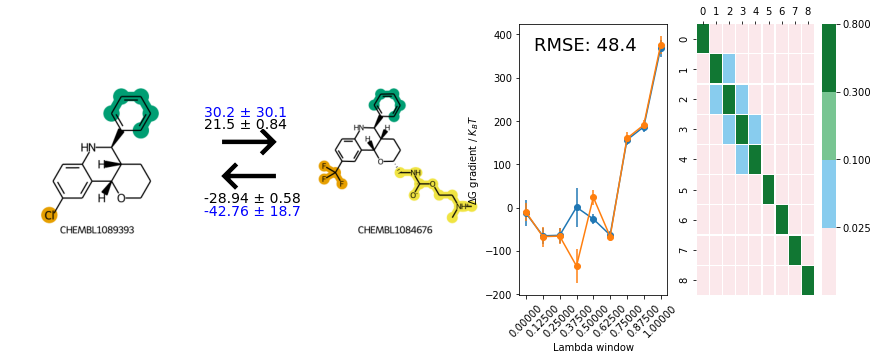

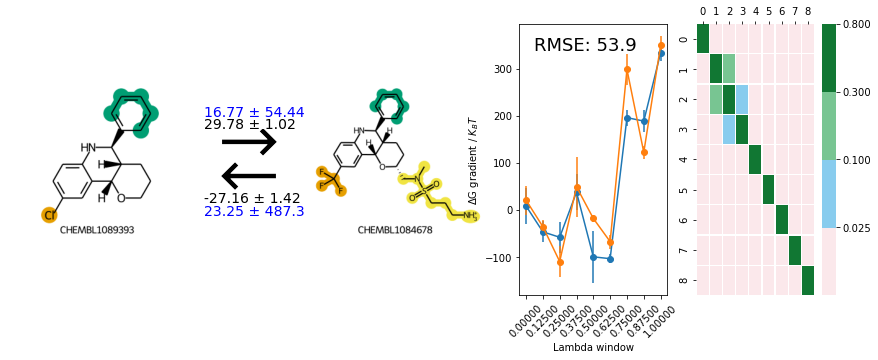

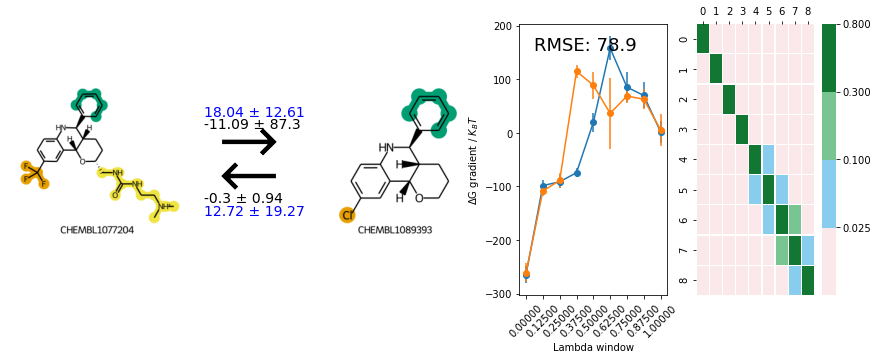

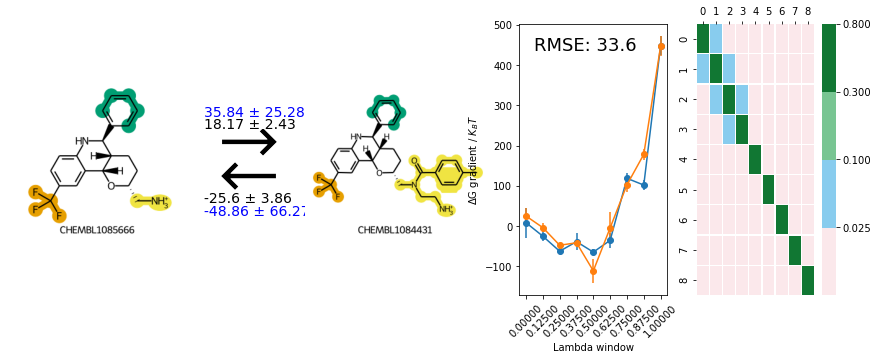

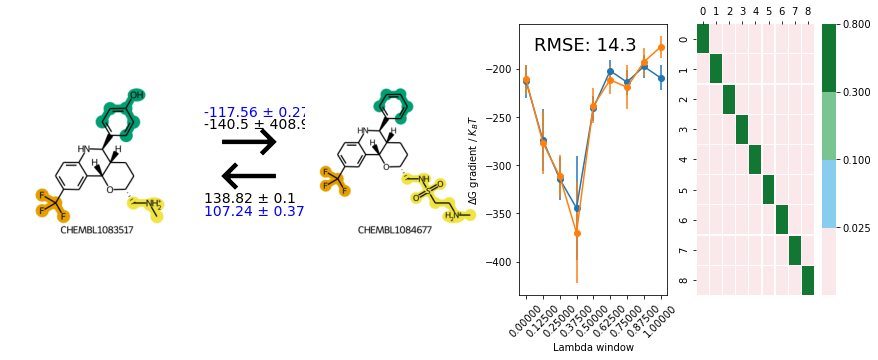

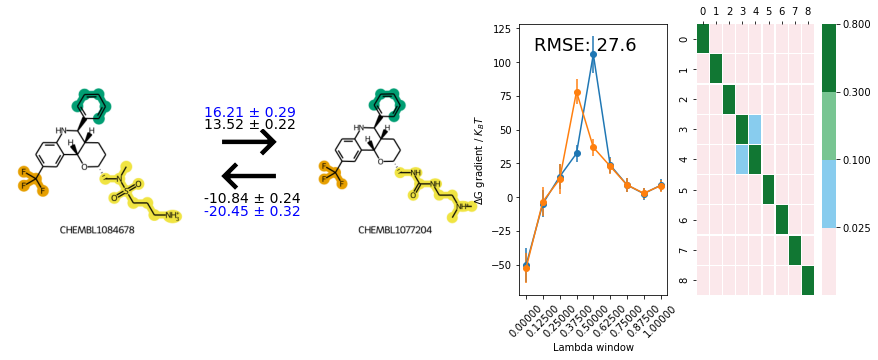

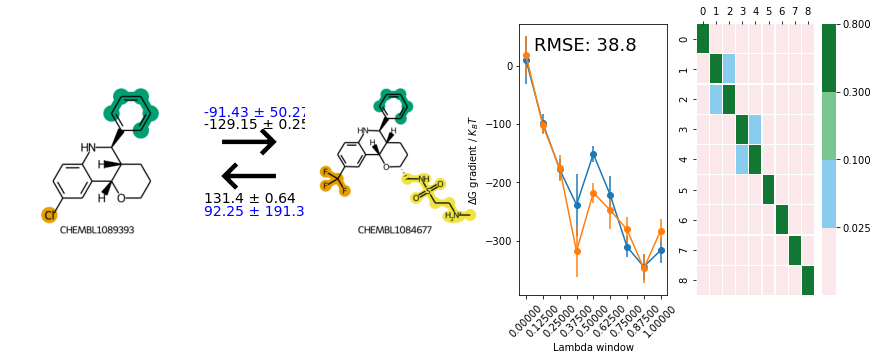

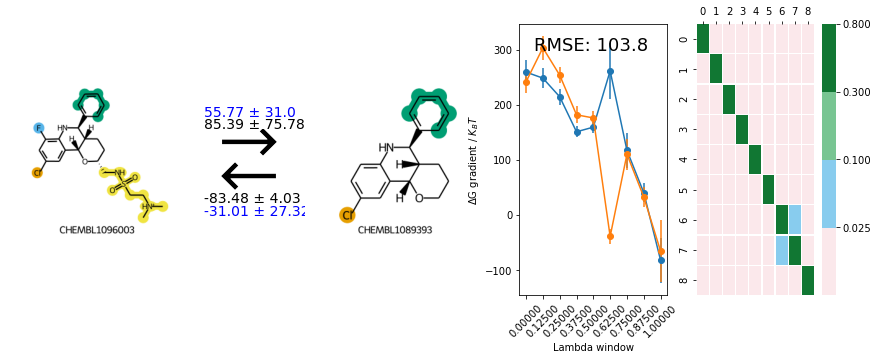

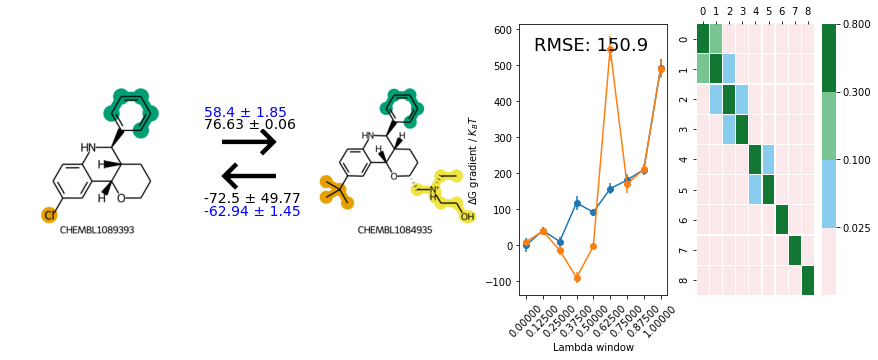

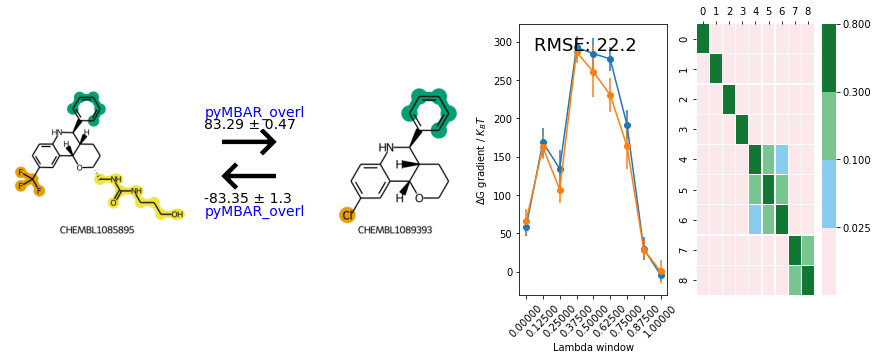

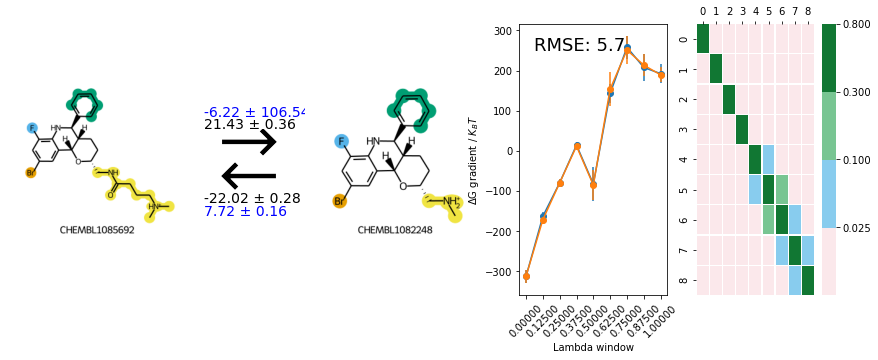

/Users/jscheen/anaconda2/envs/cresset/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jscheen/anaconda2/envs/cresset/lib/python3.7/site-packages/seaborn/matrix.py:311: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


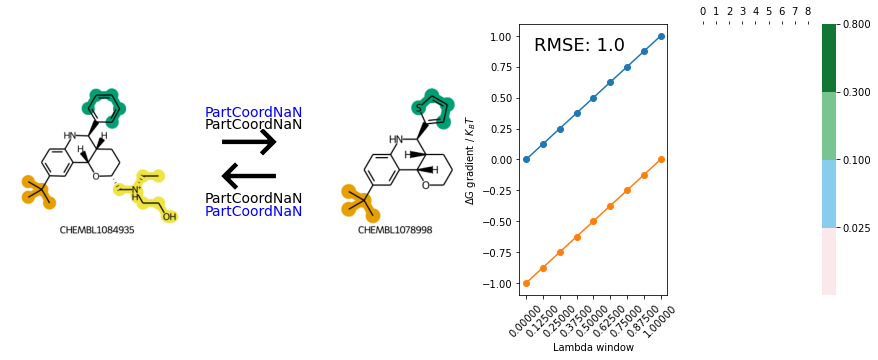

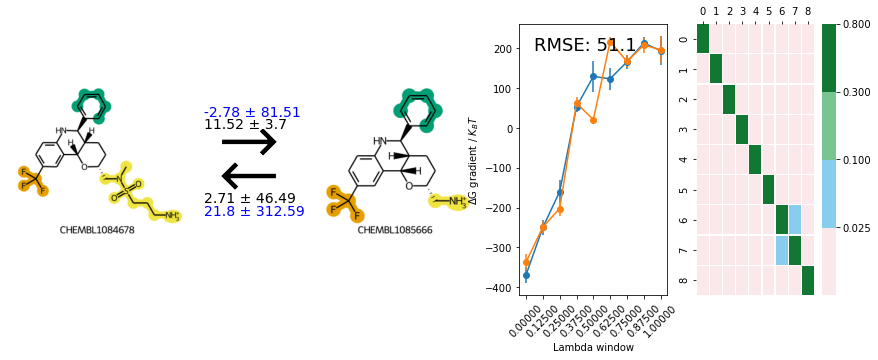

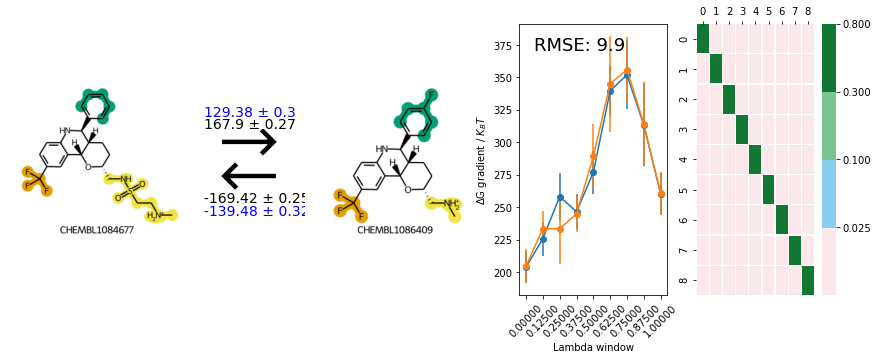

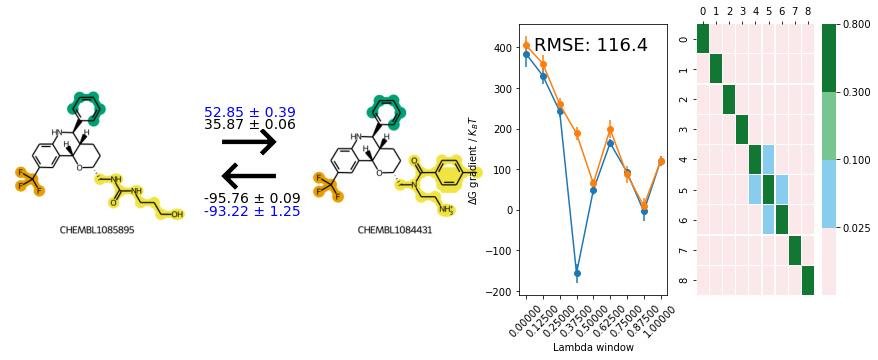

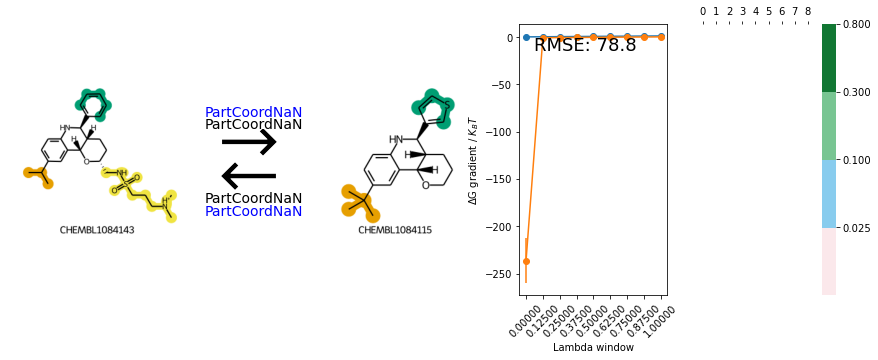

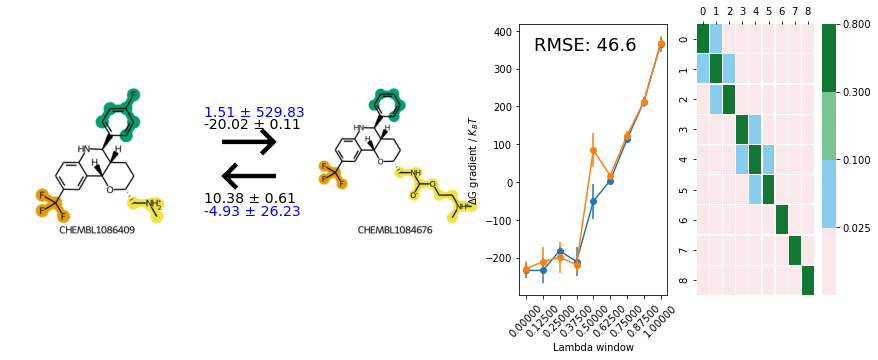

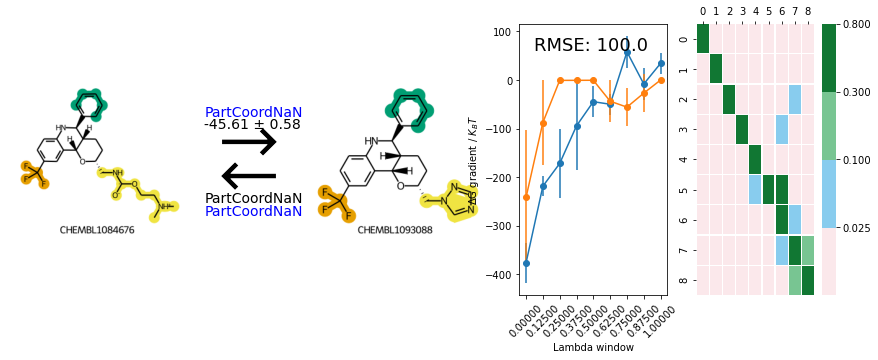

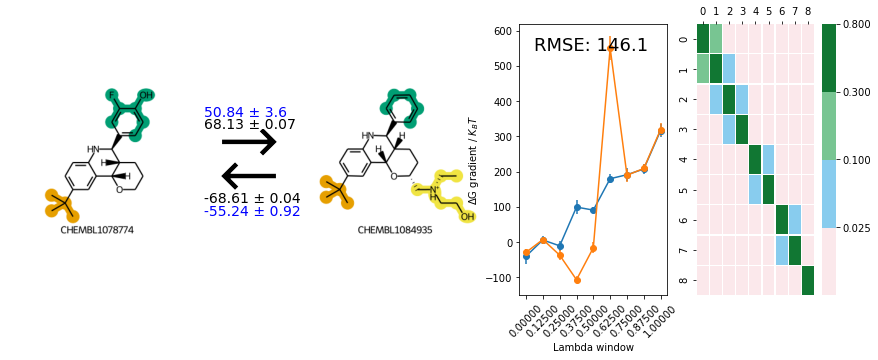

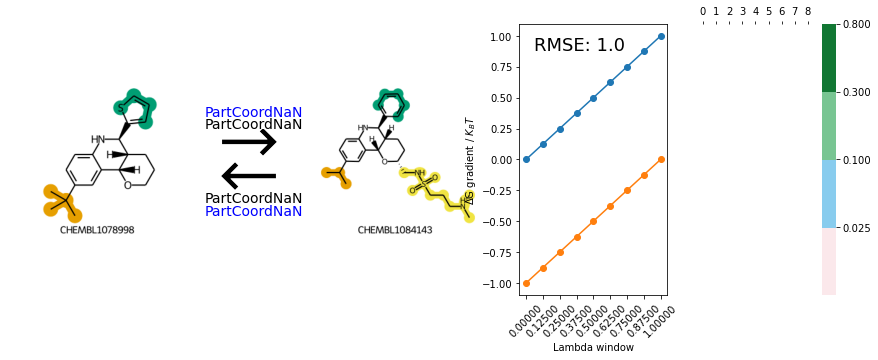

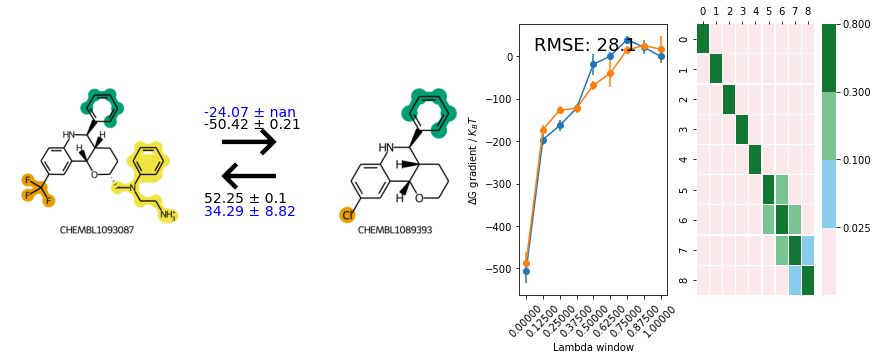

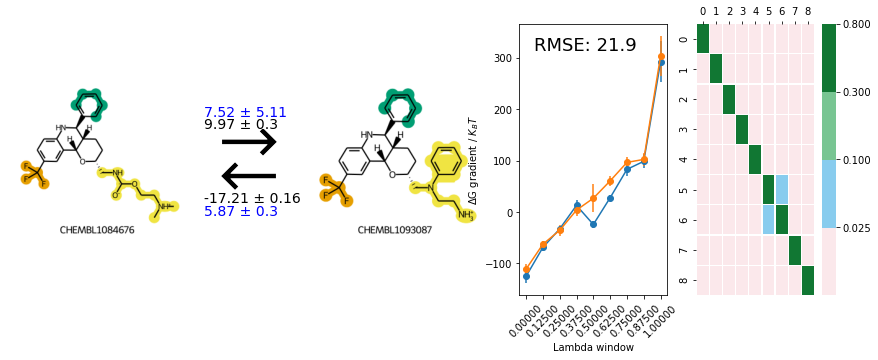

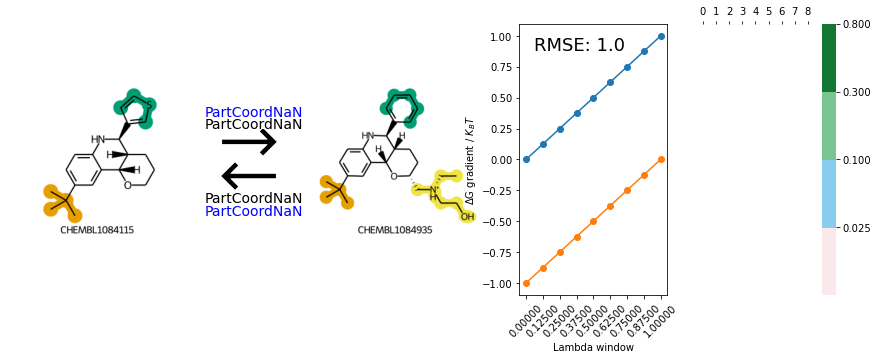

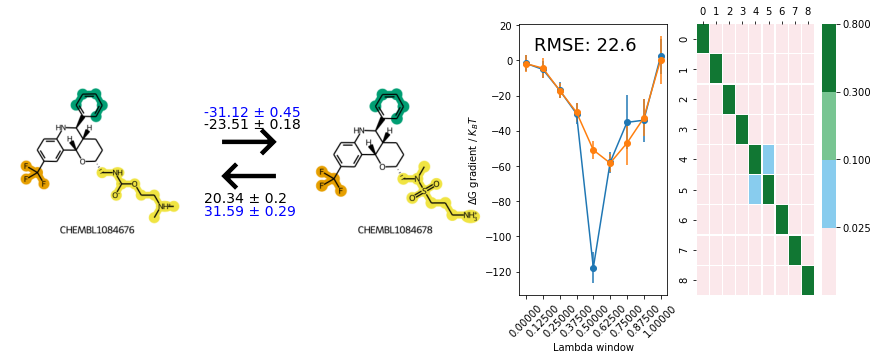

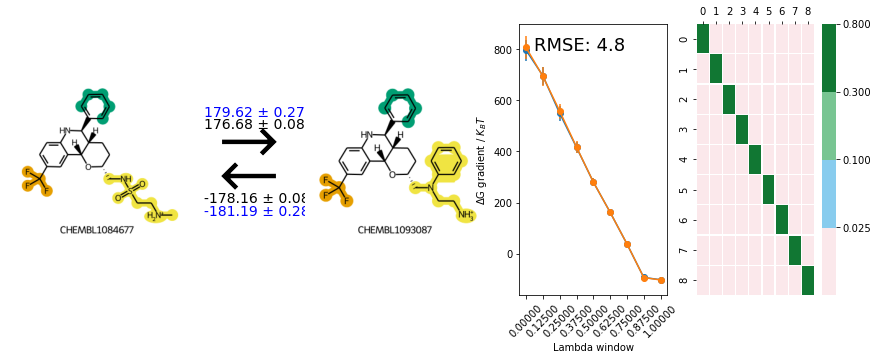

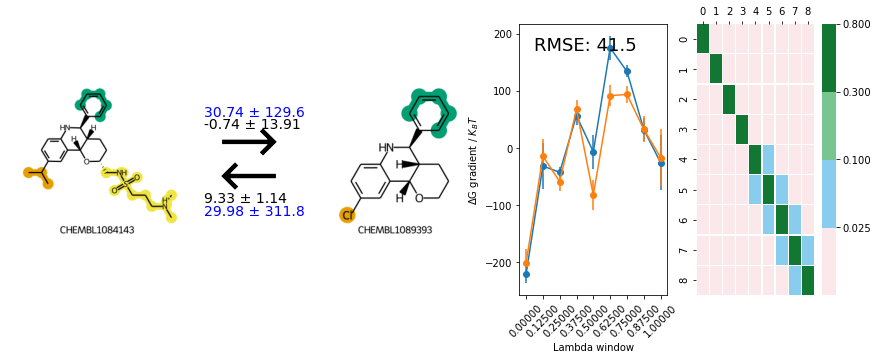

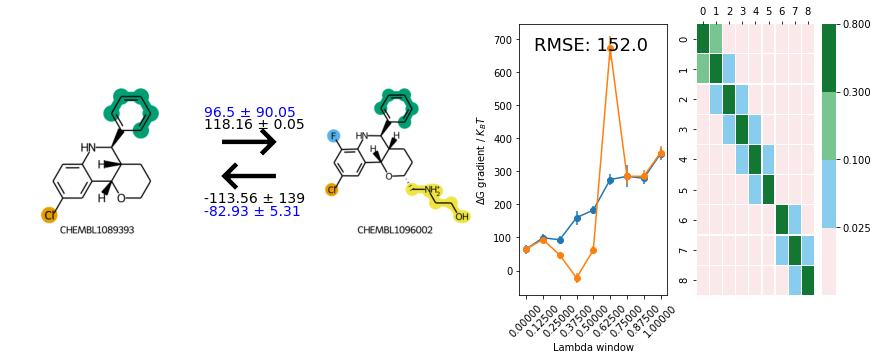

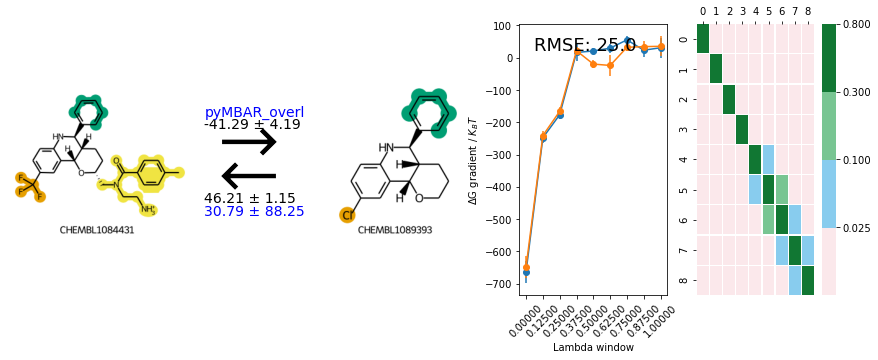

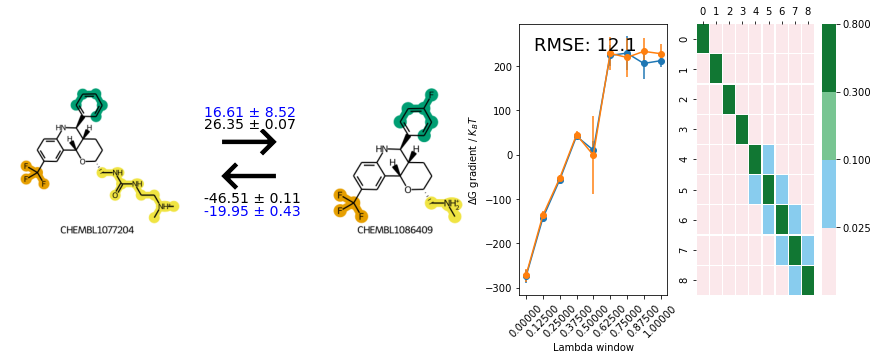

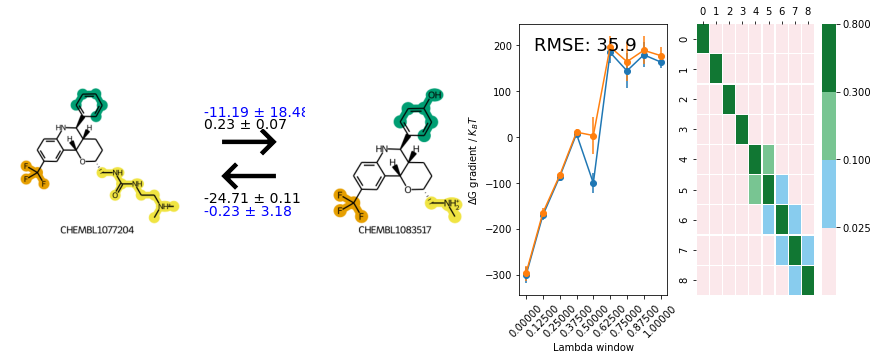

In [9]:
inv_processed = []
num_lambdas = 9
ps_overlaps_v = pd.DataFrame()
ps_overlaps_f = pd.DataFrame()


print("Perturbations; black=vacuum, blue=solvation; in kcal/mol:  Gradient + phase-space overlap (vacuum): ")
for pert, info in mbar_dict.items():

    ligA = pert.split("~")[0]
    ligB = pert.split("~")[1]
    inv_processed.append(ligB+"~"+ligA)

    inverse_info = mbar_dict[ligB+"~"+ligA]

    if not pert in inv_processed:
        imgs_path = "../pre_setup/ligands/"

        imgA = mpimg.imread(imgs_path+ligA+".png")
        arrow = mpimg.imread(imgs_path+"arrow.png")
        imgB = mpimg.imread(imgs_path+ligB+".png")

        fig, ax = plt.subplots(1,5, figsize=(15,5),  gridspec_kw={'width_ratios': [1, 0.3, 1, 0.8, 0.8]})
        ax[0].imshow(imgA)
        ax[1].imshow(arrow)
        
        
        
        # now annotate arrows with data:
        # vac:
        try:
            display_str = str(round(float(info[0]), 2))+" ± "+str(round(float(info[1]), 2))
        except ValueError:
            display_str = info[2]
        ax[1].annotate(display_str, xy=(-0.3,1), xycoords="axes fraction", size=14)
        # free:
        try:
            display_str = str(round(float(info[4]), 2))+" ± "+str(round(float(info[5]), 2))
        except ValueError:
            display_str = info[6]
        ax[1].annotate(display_str, xy=(-0.3,1.2), xycoords="axes fraction", size=14, color="blue")
        
        # repeat for inverse/reverse arrow:
        # vac:
        try:
            display_str = str(round(float(inverse_info[0]), 2))+" ± "+str(round(float(inverse_info[1]), 2))
        except ValueError:
            display_str = inverse_info[2]
        ax[1].annotate(display_str, xy=(-0.3,-0.2), xycoords="axes fraction", size=14)
        # free:
        try:
            display_str = str(round(float(inverse_info[4]), 2))+" ± "+str(round(float(inverse_info[5]), 2))
        except ValueError:
            display_str = inverse_info[6]
        ax[1].annotate(display_str, xy=(-0.3,-0.4), xycoords="axes fraction", size=14, color="blue")
        
        
        
        
        
        
        
        for axis in [ax[0], ax[1], ax[2]]:
            axis.axis('off')
            
        ax[2].imshow(imgB)
        
        # plot gradients:
        
        plotGradients(pert, axis=ax[3])
        
        # plot overlap matrix as in livecoms paper:
        ovlp_mtx = np.matrix(info[3])
        ovlp_mtx = np.reshape(ovlp_mtx, (-1, num_lambdas))
        
        
        cmap = colors.ListedColormap(['#FBE8EB','#88CCEE','#78C592', '#117733'])
        bounds=[0.0, 0.025, 0.1, 0.3,0.8]
        norm = colors.BoundaryNorm(bounds, cmap.N, clip=False)
        cbar_kws=dict(ticks=[.025, .1, .3,0.8])
        ax = sns.heatmap(ovlp_mtx,annot=False, fmt='.2f', linewidths=.3, 
                         annot_kws={"size": 14},square=False,robust=True,cmap=cmap, 
                         norm=norm,cbar_kws=cbar_kws, ax=ax[4])
        ax.xaxis.tick_top()
        
        # take the off-diagonal values and add to df if there is info:
        off_diagonal_vals = np.diagonal(ovlp_mtx, offset=1)
        if len(off_diagonal_vals) == (len(ovlp_mtx)-1):
            ps_overlaps_v[pert] = off_diagonal_vals
                
                
        # repeat for solvated:
        ovlp_mtx_f = np.matrix(info[7])
        ovlp_mtx_f = np.reshape(ovlp_mtx_f, (-1, num_lambdas))
        off_diagonal_vals_f = np.diagonal(ovlp_mtx_f, offset=1)
        if len(off_diagonal_vals_f) == (len(ovlp_mtx_f)-1):
            ps_overlaps_f[pert] = off_diagonal_vals_f

        
        # finally, plot this pert's info:        
        plt.show()

## Plot distributions:

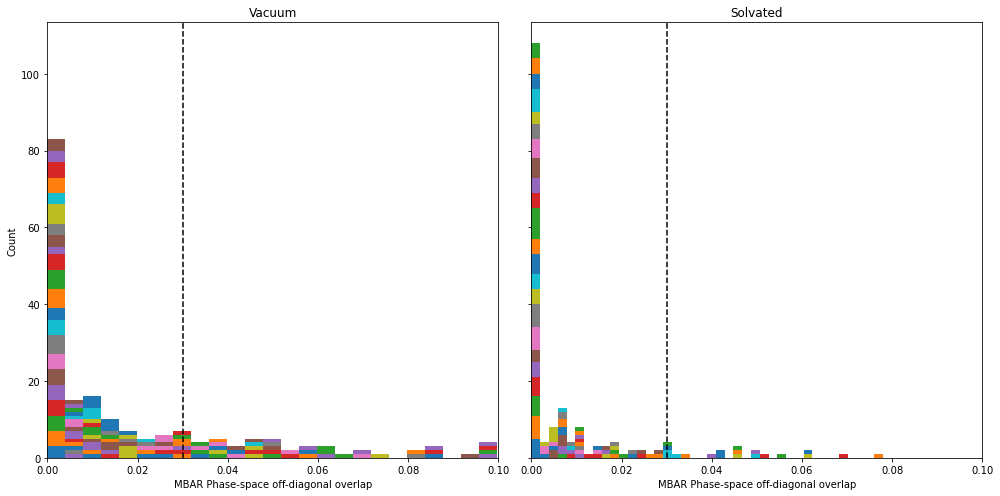

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14,7), sharey=True, sharex=True)


axes[0].hist(ps_overlaps_v.values,80, stacked=True)
axes[0].set_title("Vacuum")

axes[1].hist(ps_overlaps_f.values,40, stacked=True)
axes[1].set_title("Solvated")

axes[0].set_xlabel("MBAR Phase-space off-diagonal overlap")
axes[1].set_xlabel("MBAR Phase-space off-diagonal overlap")

axes[0].set_ylabel("Count")

axes[0].set_xlim(0, 0.1)

axes[0].axvline(0.03, ls="--", color="black")
axes[1].axvline(0.03, ls="--", color="black")

plt.tight_layout()
plt.show()
